# Dimensionality Reduction on Project Data

## Emily Woska

## 11/19/2020

V2: Attempting to see how dimensionality reduction works on the new dataset containing additional cities.

In [1]:
from sklearn.exceptions import FitFailedWarning 
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=FitFailedWarning, append=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

%matplotlib inline

In [2]:
# set current path
# set file location on your local machine
dataLoc = '../data/dataWithFeatures.csv'

In [3]:
# load dataset
# define features as all health and population indicators, without information about the COVID percentage in each zip code as that is our target
df = pd.read_csv(dataLoc)
df.dropna(inplace=True)
features = df.drop(columns=["Confirmed Cases", "Zip Code", "ZIP", "PlaceName", "COVID_perc", "white_perc", "black_perc", "native_perc", "asian_perc", "hawaii_perc", "other_perc", "two_plus_perc"])

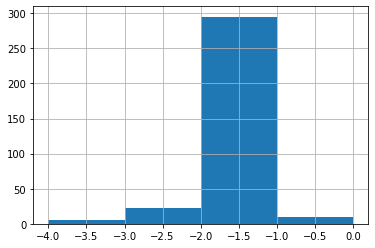

In [4]:
# determine bins that the covid percentages fit into (on log10-scale)
np.log10(df["COVID_perc"]).hist(bins=[-4, -3, -2, -1, 0])

In [5]:
# target variables correspond to the bin that log10(COVID_perc) falls within
# also capture the bin values so that we can reconstruct the bin ranges when needed
target, bins = pd.cut(np.log10(df["COVID_perc"]), bins=[-4, -3, -2, -1, 0], retbins=True, labels=range(4))
df["log_10_COVID_perc"] = target
bins = [round(bin_val, 3) for bin_val in bins]
bin_text = []
for i, bin_val in enumerate(bins[:-1]):
    bin_text.append(f"{bin_val}<=x<={bins[i+1]}")

## PCA

In [6]:
# run PCA with 3 principal components to reduce dimensionality of input features
n_components = 3
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(features.values)
for component in range(n_components):
    df[f"pca-{component}"] = pca_result[:, component]

In [7]:
# The first two principal components explain almost all of the variance
pca.explained_variance_ratio_

array([0.73223975, 0.21288783, 0.03148293])

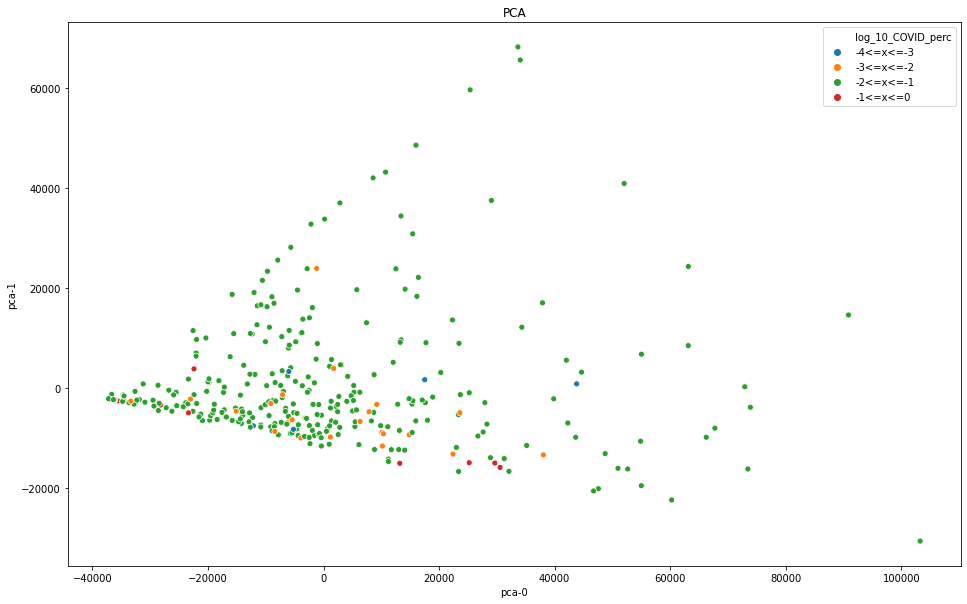

In [8]:
plt.figure(figsize=(16,10))
g = sns.scatterplot(
    x="pca-0", y="pca-1",
    hue="log_10_COVID_perc",
    palette=sns.color_palette('tab10', n_colors=4),
    data=df,
    legend="full",
)
plt.gca().set_title("PCA")
for t, l in zip(g.get_legend().texts, ["log_10_COVID_perc"] + bin_text): t.set_text(l)

The majority class ($-2<=x<=-1$) encompasses most of the embedded space, but the outlier classes ($-1<=x<=0$ and $-3<=x<=2$) do seem to at least be primarily grouped in the lower left corner.

## TSNE

In [9]:
# Run TSNE with a 2D embedding
tsne = TSNE(n_components=2, verbose=1, perplexity=6, n_iter=300)
tsne_results = tsne.fit_transform(features)
df["tsne-0"] = tsne_results[:, 0]
df["tsne-1"] = tsne_results[:, 1]

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 332 samples in 0.000s...
[t-SNE] Computed neighbors for 332 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 332 / 332
[t-SNE] Mean sigma: 1317.122005
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.148598
[t-SNE] KL divergence after 300 iterations: 0.795773


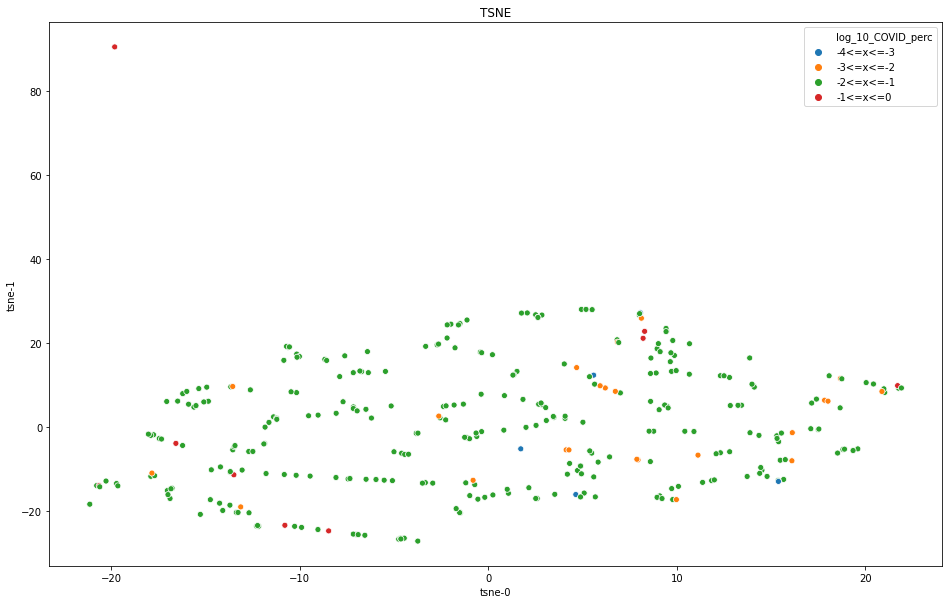

In [10]:
plt.figure(figsize=(16,10))
g = sns.scatterplot(
    x="tsne-0", y="tsne-1",
    hue="log_10_COVID_perc",
    palette=sns.color_palette('tab10', n_colors=4),
    data=df,
    legend="full",
)
plt.gca().set_title("TSNE")
for t, l in zip(g.get_legend().texts, ["log_10_COVID_perc"] + bin_text): t.set_text(l)

There isn't clear separation between data points that fall into different bins from the plot above.  Data points within the outlier bins don't seem to be grouped too tightly together.

## TSNE + PCA

In [11]:
# Run TSNE against the PCA data instead of the original features, again embedding within a 2D space
tsne_pca = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne_pca.fit_transform(pca_result)
df['tsne-pca-0'] = tsne_pca_results[:,0]
df['tsne-pca-1'] = tsne_pca_results[:,1]

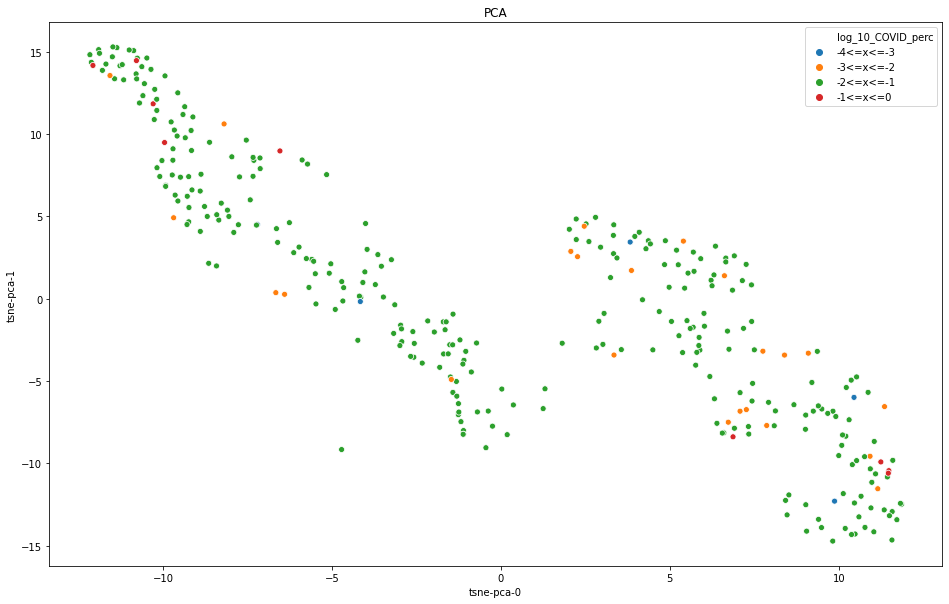

In [12]:
plt.figure(figsize=(16,10))
g = sns.scatterplot(
    x="tsne-pca-0", y="tsne-pca-1",
    hue="log_10_COVID_perc",
    palette=sns.color_palette('tab10', n_colors=4),
    data=df,
    legend="full",
)
plt.gca().set_title("PCA")
for t, l in zip(g.get_legend().texts, ["log_10_COVID_perc"] + bin_text): t.set_text(l)

There still isn't clear separation between data points that fall into different bins from the plot above.  Data points within the outlier bins don't seem to be grouped too tightly together.

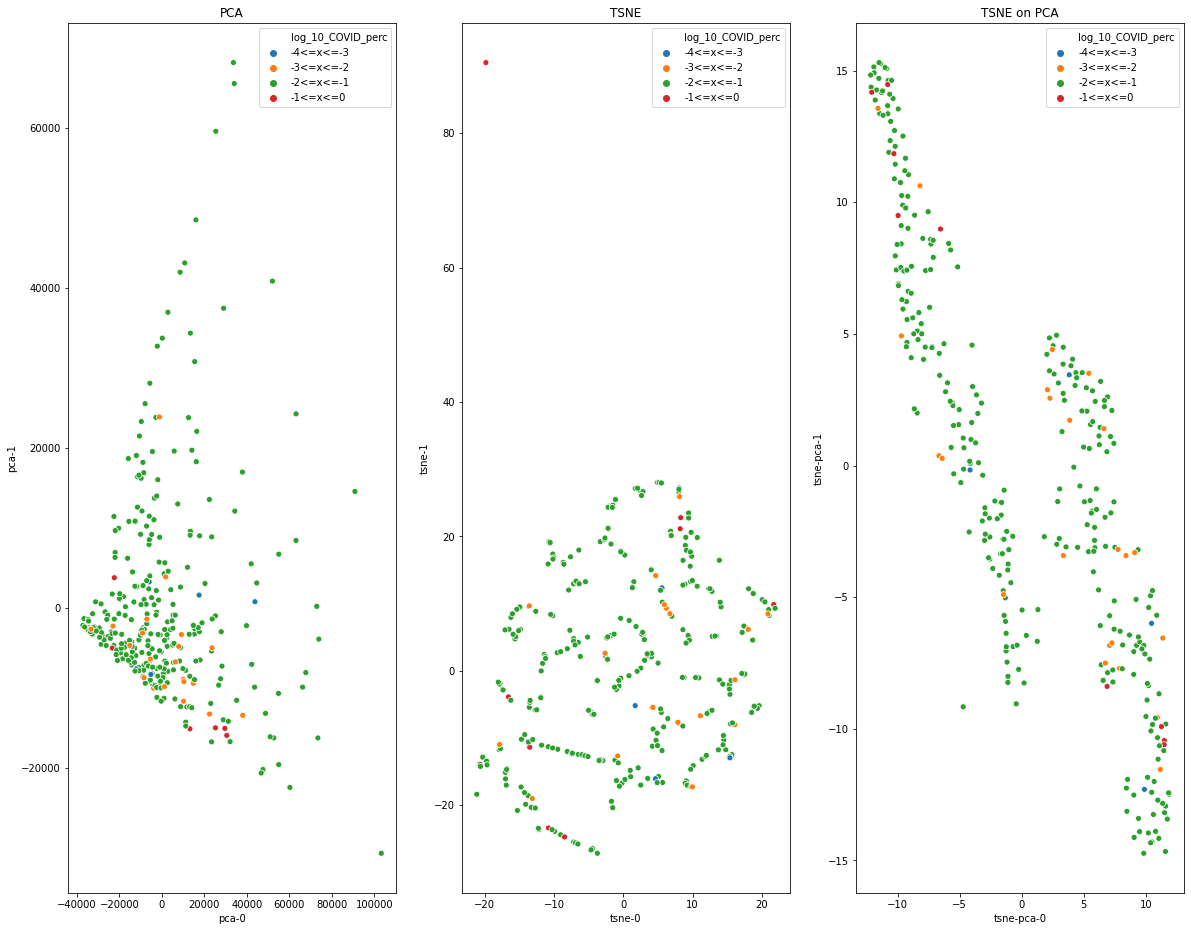

In [13]:
# Plot all three images together for ease of viewing
plt.figure(figsize=(20,16))
ax1 = plt.subplot(1, 3, 1)
g = sns.scatterplot(
    x="pca-0", y="pca-1",
    hue="log_10_COVID_perc",
    palette=sns.color_palette('tab10', n_colors=4),
    data=df,
    legend="full",
    ax=ax1
)
ax1.set_title("PCA")
for t, l in zip(g.get_legend().texts, ["log_10_COVID_perc"] + bin_text): t.set_text(l)
ax2 = plt.subplot(1, 3, 2)
g = sns.scatterplot(
    x="tsne-0", y="tsne-1",
    hue="log_10_COVID_perc",
    palette=sns.color_palette('tab10', n_colors=4),
    data=df,
    legend="full",
    ax=ax2
)
ax2.set_title("TSNE")
for t, l in zip(g.get_legend().texts, ["log_10_COVID_perc"] + bin_text): t.set_text(l)
ax3 = plt.subplot(1, 3, 3)
g = sns.scatterplot(
    x="tsne-pca-0", y="tsne-pca-1",
    hue="log_10_COVID_perc",
    palette=sns.color_palette('tab10', n_colors=4),
    data=df,
    legend="full",
    ax=ax3
)
ax3.set_title("TSNE on PCA")
for t, l in zip(g.get_legend().texts, ["log_10_COVID_perc"] + bin_text): t.set_text(l)    

## Model Training on Reduced Data

In [14]:
# split train and holdout dataset for both original data and reduced PCA data
train_size = 0.75
original_x_train, original_x_test, original_y_train, original_y_test = train_test_split(features, target, train_size=train_size, stratify=target, random_state=12345)
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(pca_result, target, train_size=train_size, stratify=target, random_state=12345)
tsne_x_train, tsne_x_test, tsne_y_train, tsne_y_test = train_test_split(tsne_results, target, train_size=train_size, stratify=target, random_state=12345)
tsne_pca_x_train, tsne_pca_x_test, tsne_pca_y_train, tsne_pca_y_test = train_test_split(tsne_pca_results, target, train_size=train_size, stratify=target, random_state=12345)

### Random Forest

In [15]:
# Define GridSearch parameters
rf_params = {"n_estimators": [2, 5, 10, 25, 100], "max_depth": [2, 5, 10, 25, 100, None]}

#### Random Forest on Original Features

In [16]:
rf_clf_original = GridSearchCV(RandomForestClassifier(), rf_params, verbose=10, n_jobs=-1)
rf_clf_original.fit(original_x_train, original_y_train)
rf_clf_original.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1949s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1187s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 127 out of 150 | elapsed:    4.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 150 out o

{'max_depth': 2, 'n_estimators': 2}

In [17]:
rf_clf_original.score(original_x_test, original_y_test)

0.891566265060241

#### Random Forest on PCA Reduced Data

In [18]:
rf_clf_pca = GridSearchCV(RandomForestClassifier(), rf_params, verbose=10, n_jobs=-1)
rf_clf_pca.fit(pca_x_train, pca_y_train)
rf_clf_pca.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0986s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1447s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 127 out of 150 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished


{'max_depth': 2, 'n_estimators': 10}

In [19]:
rf_clf_pca.score(pca_x_test, pca_y_test)

0.891566265060241

#### Random Forest on TSNE Reduced Data

In [20]:
rf_clf_tsne = GridSearchCV(RandomForestClassifier(), rf_params, verbose=10, n_jobs=-1)
rf_clf_tsne.fit(tsne_x_train, tsne_y_train)
rf_clf_tsne.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0108s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1302s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1754s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 127 out of 150 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished


{'max_depth': 2, 'n_estimators': 5}

In [21]:
rf_clf_tsne.score(tsne_x_test, tsne_y_test)

0.891566265060241

#### Random Forest on TSNE + PCA Reduced Data

In [22]:
rf_clf_tsne_pca = GridSearchCV(RandomForestClassifier(), rf_params, verbose=10, n_jobs=-1)
rf_clf_tsne_pca.fit(tsne_pca_x_train, tsne_pca_y_train)
rf_clf_tsne_pca.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0101s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1280s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1867s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished


{'max_depth': 2, 'n_estimators': 2}

In [23]:
rf_clf_tsne_pca.score(tsne_pca_x_test, tsne_pca_y_test)

0.891566265060241

### Logistic Regression

In [24]:
# Define GridSearch parameters
lr_params = {"penalty": ["l1", "l2", "elasticnet", None], "class_weight": ["balanced", None]}

#### Logistic Regression on Original Features

In [25]:
lr_clf_original = GridSearchCV(LogisticRegression(), lr_params, verbose=10, n_jobs=-1)
lr_clf_original.fit(original_x_train, original_y_train)
lr_clf_original.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.2s finished


{'class_weight': None, 'penalty': 'l2'}

In [26]:
lr_clf_original.score(original_x_test, original_y_test)

0.8554216867469879

#### Logistic Regression on PCA Reduced Features

In [27]:
lr_clf_pca = GridSearchCV(LogisticRegression(), lr_params, verbose=10, n_jobs=-1)
lr_clf_pca.fit(pca_x_train, pca_y_train)
lr_clf_pca.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0063s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


{'class_weight': None, 'penalty': 'l2'}

In [28]:
lr_clf_pca.score(pca_x_test, pca_y_test)

0.891566265060241

#### Logistic Regression on TSNE Reduced Features

In [29]:
lr_clf_tsne = GridSearchCV(LogisticRegression(), lr_params, verbose=10, n_jobs=-1)
lr_clf_tsne.fit(tsne_x_train, tsne_y_train)
lr_clf_tsne.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0070s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


{'class_weight': None, 'penalty': 'l2'}

In [30]:
lr_clf_tsne.score(tsne_x_test, tsne_y_test)

0.891566265060241

#### Logistic Regression on TSNE + PCA Reduced Features

In [31]:
lr_clf_tsne_pca = GridSearchCV(LogisticRegression(), lr_params, verbose=10, n_jobs=-1)
lr_clf_tsne_pca.fit(tsne_pca_x_train, tsne_pca_y_train)
lr_clf_tsne_pca.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0081s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


{'class_weight': None, 'penalty': 'l2'}

In [32]:
lr_clf_tsne_pca.score(tsne_pca_x_test, tsne_pca_y_test)

0.891566265060241

### SVM

In [33]:
# Define GridSearch parameters
svm_params = {"kernel": ["linear", "poly", "rbf", "sigmoid"], "gamma": ["scale", "auto"], "class_weight": ["balanced", None], "max_iter": [100000]}

#### SVM on Original Features

In [34]:
svm_clf_original = GridSearchCV(SVC(), svm_params, verbose=10, n_jobs=-1)
svm_clf_original.fit(original_x_train, original_y_train)
svm_clf_original.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0345s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 out of  80 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  57 out of  80 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.8s finished


{'class_weight': 'balanced',
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': 100000}

In [35]:
svm_clf_original.score(original_x_test, original_y_test)

0.891566265060241

#### SVM on PCA Reduced Features

In [36]:
svm_clf_pca = GridSearchCV(SVC(), svm_params, verbose=10, n_jobs=-1)
svm_clf_pca.fit(pca_x_train, pca_y_train)
svm_clf_pca.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0397s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  57 out of  80 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished


{'class_weight': 'balanced',
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': 100000}

In [37]:
svm_clf_pca.score(pca_x_test, pca_y_test)

0.891566265060241

#### SVM on TSNE Reduced Features

In [38]:
svm_clf_tsne = GridSearchCV(SVC(), svm_params, verbose=10, n_jobs=-1)
svm_clf_tsne.fit(tsne_x_train, tsne_y_train)
svm_clf_tsne.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0337s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0975s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  57 out of  80 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished


{'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 100000}

In [39]:
svm_clf_tsne.score(tsne_x_test, tsne_y_test)

0.8554216867469879

#### SVM on TSNE + PCA Reduced Features

In [40]:
svm_clf_tsne_pca = GridSearchCV(SVC(), svm_params, verbose=10, n_jobs=-1)
svm_clf_tsne_pca.fit(tsne_pca_x_train, tsne_pca_y_train)
svm_clf_tsne_pca.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0171s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1332s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  48 out of  80 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished


{'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 100000}

In [41]:
svm_clf_tsne_pca.score(tsne_pca_x_test, tsne_pca_y_test)

0.8674698795180723

### Neural Network

In [42]:
# Define GridSearch parameters
nn_params = {"hidden_layer_sizes": [(20), (20, 10), (20, 10, 20)], "activation": ["identity", "logistic", "tanh", "relu"], "learning_rate": ["constant", "invscaling", "adaptive"]}

#### NN on Original Features

In [43]:
nn_clf_original = GridSearchCV(MLPClassifier(), nn_params, verbose=10, n_jobs=-1)
nn_clf_original.fit(original_x_train, original_y_train)
nn_clf_original.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1338s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 157 out of 180 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed:    4.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.0s finished


{'activation': 'logistic',
 'hidden_layer_sizes': 20,
 'learning_rate': 'constant'}

In [44]:
nn_clf_original.score(original_x_test, original_y_test)

0.891566265060241

#### NN on PCA Reduced Features

In [45]:
nn_clf_pca = GridSearchCV(MLPClassifier(), nn_params, verbose=10, n_jobs=-1)
nn_clf_pca.fit(pca_x_train, pca_y_train)
nn_clf_pca.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0962s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.2s finished


{'activation': 'logistic',
 'hidden_layer_sizes': 20,
 'learning_rate': 'constant'}

In [46]:
nn_clf_pca.score(pca_x_test, pca_y_test)

0.891566265060241

#### NN on TSNE Reduced Features

In [47]:
nn_clf_tsne = GridSearchCV(MLPClassifier(), nn_params, verbose=10, n_jobs=-1)
nn_clf_tsne.fit(tsne_x_train, tsne_y_train)
nn_clf_tsne.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1341s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.5s finished


{'activation': 'identity',
 'hidden_layer_sizes': 20,
 'learning_rate': 'constant'}

In [48]:
nn_clf_tsne.score(tsne_x_test, tsne_y_test)

0.891566265060241

#### NN on TSNE + PCE Reduced Features

In [49]:
nn_clf_tsne_pca = GridSearchCV(MLPClassifier(), nn_params, verbose=10, n_jobs=-1)
nn_clf_tsne_pca.fit(tsne_pca_x_train, tsne_pca_y_train)
nn_clf_tsne_pca.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1303s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 157 out of 180 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 176 out of 180 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.5s finished


{'activation': 'identity',
 'hidden_layer_sizes': 20,
 'learning_rate': 'constant'}

In [50]:
nn_clf_tsne_pca.score(tsne_pca_x_test, tsne_pca_y_test)

0.891566265060241

## Model Training Analysis

Above, we trained multiple different models (Random Forest, Logistic Regression, SVM, and Neural Network) on both the original features and the reduced features after running PCA.  The table below shows the results of this training and score on the holdout data.

| Model | Data | Best Parameters | Holdout Score |
| --- | --- | --- | --- |
| Random Forest | Original | max_depth: 2<br>n_estimators: 2 | 0.891566265060241 |
| Random Forest | PCA | max_depth: 2<br>n_estimator: 10 | 0.891566265060241 |
| Random Forest | TSNE | max_depth: 2<br>n_estimators: 5 | 0.891566265060241 |
| Random Forest | TSNE + PCA | max_depth: 2<br>n_estimator: 2 | 0.891566265060241 |
| Logistic Regression | Original | class_weight: None<br>penalty: 'l2' | 0.8554216867469879 |
| Logistic Regression | PCA | class_weight: None<br>penalty: 'l2' | 0.891566265060241 |
| Logistic Regression | TSNE | class_weight: None<br>penalty: 'l2' | 0.891566265060241 |
| Logistic Regression | PCA + TSNE | class_weight: None<br>penalty: 'l2' | 0.891566265060241 |
| SVM | Original | class_weight: 'balanced'<br>gamma: 'auto'<br>kernel: 'rbf'<br>max_iter: 100000 | 0.891566265060241 |
| SVM | PCA | class_weight: 'balanced'<br>gamma: 'auto'<br>kernel: 'rbf'<br>max_iter: 100000 | 0.891566265060241 |
| SVM | TSNE | class_weight: None<br>gamma: 'auto'<br>kernel: 'rbf'<br>max_iter: 100000 | 0.8554216867469879 |
| SVM | TSNE + PCA | class_weight: None<br>gamma: 'auto'<br>kernel: 'rbf'<br>max_iter: 100000 | 0.8674698795180723 |
| Neural Network | Original | activation: 'logistic'<br>hidden_layer_sizes: (20)<br>learning_rate: 'constant' | 0.891566265060241 |
| Neural Network | PCA | activation: 'logistic'<br>hidden_layer_sizes: (20)<br>learning_rate: 'constant' | 0.891566265060241 |
| Neural Network | TSNE | activation: 'identity'<br>hidden_layer_sizes: (20)<br>learning_rate: 'constant' | 0.891566265060241 |
| Neural Network | TSNE + PCA | activation: 'identity'<br>hidden_layer_sizes: (20)<br>learning_rate: 'constant' | 0.891566265060241 |

For ease of comparison, the table from our last analysis on fewer cities is copied below.

| Model | Data | Best Parameters | Holdout Score |
| --- | --- | --- | --- |
| Random Forest | Original | max_depth: 5<br>n_estimators: 100 | 0.9305555555555556 |
| Random Forest | PCA | max_depth: 2<br>n_estimator: 5 | 0.8888888888888888 |
| Random Forest | TSNE | max_depth: 2<br>n_estimators: 5 | 0.8888888888888888 |
| Random Forest | TSNE + PCA | max_depth: 2<br>n_estimator: 5 | 0.8888888888888888 |
| Logistic Regression | Original | class_weight: None<br>penalty: l2 | 0.9305555555555556 |
| Logistic Regression | PCA | class_weight: None<br>penalty: l2 | 0.8888888888888888 |
| Logistic Regression | TSNE | class_weight: None<br>penalty: l2 | 0.8888888888888888 |
| Logistic Regression | PCA + TSNE | class_weight: None<br>penalty: l2 | 0.8888888888888888 |
| SVM | Original | class_weight: 'balanced'<br>gamma: 'auto'<br>kernel: 'rbf'<br>max_iter: 100000 | 0.8888888888888888 |
| SVM | PCA | class_weight: 'balanced'<br>gamma: ''<br>kernel: ''<br>max_iter: 100000 | 0.8888888888888888 |
| SVM | TSNE | class_weight: None<br>gamma: ''<br>kernel: ''<br>max_iter: 100000 | 0.8888888888888888 |
| SVM | TSNE + PCA | class_weight: None<br>gamma: ''<br>kernel: ''<br>max_iter: 100000 | 0.8888888888888888 |
| Neural Network | Original | activation: 'tanh'<br>hidden_layer_sizes: <br>learning_rate: 'constant' | 0.8888888888888888 |
| Neural Network | PCA | activation: 'logistic'<br>hidden_layer_sizes: <br>learning_rate: 'constant' | 0.8888888888888888 |
| Neural Network | TSNE | activation: 'identity'<br>hidden_layer_sizes: <br>learning_rate: 'constant' | 0.8888888888888888 |
| Neural Network | TSNE + PCA | activation: 'identity'<br>hidden_layer_sizes: <br>learning_rate: 'constant' | 0.8888888888888888 |